<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Pipeline Tutorial SWDB 2022 </h1> 
<h3 align="center">Monday, August 29, 2022</h3> 

## Model selection with Scikit-Learn pipelines

The last few tutorials have introduced tools that are built into sklearn. This one is a little different; here, we will learn how to string the tools that we have already seen into useful data pipelines.

In this tutorial, we will learn:

- How to use scikit-learn "Pipeline" to chain together multiple steps in a decoding analysis
- How to cross-validate your pipeline
- How to search hyperparameters to optimize your model
- How to apply your pipeline to new data

This tutorial is going to work through building a model to decode the identity of images as durring the "Visual Behavior" task.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import allensdk
from allensdk.brain_observatory.\
    behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
import os
import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

# get the cache location
cache_dir = os.path.join(data_root, data_dirname)


#cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=cache_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=use_static)

Lets refind the "Best" V1 Session we used before, and get the spiketimes and behavior data from that session.

There is nothing new about this code, its exactly the same as what we used in the "Classification" tutorial

In [3]:
# We are going to find the "familiar" session that contains the most V1 units. 
area = 'VISp'
# You have actually seen this code before, so we won't spend time on it...
units_table = cache.get_unit_table()
ecephys_sessions_table = cache.get_ecephys_session_table()

# For now, we are going to grab the one with the most V! units.
unit_by_session = units_table.join(ecephys_sessions_table,on = 'ecephys_session_id')
unit_in = unit_by_session[(unit_by_session['structure_acronym']==area) &\
                          (unit_by_session['experience_level']=='Familiar') &\
                          (unit_by_session['isi_violations']<.5)&\
                          (unit_by_session['amplitude_cutoff']<0.1)&\
                          (unit_by_session['presence_ratio']>0.95)]
unit_count = unit_in.groupby(["ecephys_session_id"]).count()
familiar_session_with_most_in_units = unit_count.index[np.argmax(unit_count['ecephys_probe_id'])]
# Actually imort the data
session = cache.get_ecephys_session(ecephys_session_id=familiar_session_with_most_in_units)

# Get unit information
session_units = session.get_units()
# Channel information
session_channels = session.get_channels()
# And accosiate each unit with the channel on which it was found with the largest amplitude
units_by_channels= session_units.join(session_channels,on = 'peak_channel_id')

# Filter for units in primary visual cortex
this_units = units_by_channels[(units_by_channels.structure_acronym == area)\
                               &(units_by_channels['isi_violations']<.5)\
                               &(units_by_channels['amplitude_cutoff']<0.1)\
                               &(units_by_channels['presence_ratio']>0.95)]
# Get the spiketimes from these units as a dictionary
this_spiketimes = dict(zip(this_units.index, [session.spike_times[ii] for ii in this_units.index]))


C:\Users\yoni.browning\Anaconda3\envs\swdb_allensdk\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Recall that, decode the identity of individual image presentations from the population activity, we need the following

- `y` - vector of integers, where each integer corresponds to a particular image
- `X` - array of floats, where each column is the activity of a single neuron in response to a given natural scene presentation. Each row of this array is often called a "population vector"

The process of getting to `X` from raw data (in this case, the response of a neuron) is sometimes known as "feature engineering". This involves multiple decisions that will be specific to the dataset at hand, but can include the time window to include, how to smooth data, whether to do dimensionality reduction on data, etc.

Here, "y" is the same trial-by-trial image identity we used in the last tutorial:

In [4]:
active_stims = session.stimulus_presentations[session.stimulus_presentations.stimulus_block==0 ]
# Get an integer value for each image name
[unq,y]= np.unique(active_stims.image_name,return_inverse=True)


Before, we built 'X' by finding the number of spikes in the first 250 ms of the trial. For this tutorial, we will do something slightly more complicated. We are going to look at time bins after each stimulus presentation, so we will count the number of spikes 0-50ms after each presentation, 50-100ms after each presentation, etc. This is very similar to constructing a PSTH, but we are going to keep each neurons response on each trial seperate so that we can try to decode trial identify.

First, we need a time vector.

In [5]:
# Look we want to look at time 750 ms after the start of the trial.
dt = .05 # Time is in seconds
tme = np.arange(0,.75+dt,dt)
tme

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75])

We will now put bin the data on a trial by trial basis. `Xbins` will now have dimensions (Trials,Neurons,TimeBins). It takes a moment to calculate.

In [6]:
# Declare and empty variable X
Xbins = np.zeros((len(active_stims),len(this_spiketimes),len(tme)-1))
# This Loop is a little slow...be patient
# Loop Through both trials and units, counting the number of spikes
for jj,key in enumerate(this_spiketimes):
    # Loop through the trials
    for ii, trial in active_stims.iterrows():
        startInd = np.searchsorted(this_spiketimes[key], trial.start_time)
        endInd = np.searchsorted(this_spiketimes[key], trial.start_time+.75+dt)
        # Count the number of spikes per trial. 
        Xbins[ii,jj,:] = np.histogram(this_spiketimes[key][startInd:endInd]-trial.start_time,tme)[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


# Setting up a pipeline

Now that we have `X` and `y`, we are ready to start developing our decoding pipeline.

This is going to have a few major steps. We will:
- Choose a some data to use to optimize our parameters
- Split these data into a 'train' and test set
- Preprocess these data (Zero mean)
- Do dimensionality reduction
- Fit a classifier
These are all things you have seen in past tutorials; if any of this is weird, please refer back to those!

Because there is a lot there, you will see that it is usefull to streamline these steps into a single pipeline!

We know from the classification tutorial that the first 250 ms after stimulus onset is easily decodable in V1. To establish our pipleline, take just this portion of `Xbins`. Don't worry, we have a change to play around with the rest of these data in the excersizes.

In [7]:
X = np.sum(Xbins[:,:,tme[:-1]<=.250],axis=2)

##  Split the data into training and testing sets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    stratify=y, # this makes sure that our training and testing sets both have all classes in y
)

## Rescale the data to zero mean and unit variance

Before we did this manually, but sklearn provides the `StandardScalar` that does this automatically

In [9]:
from sklearn.preprocessing import StandardScaler
rescaler = StandardScaler()
X_train_rescaled = rescaler.fit_transform(X_train)

## Reduce the dimensionality of the data

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_rescaled)

## Train a classifier


In [11]:
# do the classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
classifier = LinearDiscriminantAnalysis()
scores = cross_val_score(classifier, X_train_reduced, y_train, cv=5)
scores

array([0.98828125, 0.98567708, 0.98565841, 0.98435463, 0.98826597])

## Assemble these steps into a Pipeline

We now have 3 steps in our processing pipeline... rescaling, reducing, and classifying. Keeping track of these steps and their intermediate variables can get confusing.

Luckily, since each of these steps use objects that conform to the scikit-learn fit/transform/predict standard, we can use the scikit learn pipeline module to assemble them into a pipeline, which itself has fit & predict methods, so it can drop into functions like `cross_val_score`.


In [12]:
from sklearn.pipeline import Pipeline

In [13]:
pipeline = Pipeline((
    ('rescaler', StandardScaler()),
    ('reducer', PCA(n_components=20)),
    ('classifier', LinearDiscriminantAnalysis()),
))

In [14]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores

array([0.95963542, 0.96223958, 0.95958279, 0.9517601 , 0.96479791])

## Optimizing the pipeline

Now that we've defined a pipeline, we can more readily adjust parts of the pipeline to improve it... adjust the parameters for each step, remove steps, replace one classifier with another. These pieces of an ML pipeline are aften referred to as "hyperparameters".

If we want to do this exploration strategically, we can search over this space to select the best hyperparameters. One way to do this is with scikit-learn's `GridSearchCV`. This lets us do the following....

- specify a set of parameters we want to search over
- for each combination of parameters, do an n-fold cross validation
- rank the parameter combinations based on their average cross validation performance

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


N_FEATURES_OPTIONS = [20, 40, 80,]

param_grid = [
    {
        'rescaler': [None, StandardScaler()],
        'reducer__n_components': N_FEATURES_OPTIONS,
        'classifier': [
            LinearDiscriminantAnalysis(),
            KNeighborsClassifier(n_neighbors=50),
            DecisionTreeClassifier(),
        ]
    },
]

In [16]:
grid = GridSearchCV(pipeline, param_grid)

In [17]:
grid.fit(X_train, y_train)
grid.best_estimator_

Pipeline(steps=[('rescaler', StandardScaler()),
                ('reducer', PCA(n_components=80)),
                ('classifier', LinearDiscriminantAnalysis())])

`GridSearchCV` stores the scores from each cross validation run, so we can go at our parameter space.

In [18]:
import pandas as pd
cv_results = pd.DataFrame(grid.cv_results_)

In [19]:
cv_results['param_rescaler'] = ~pd.isnull(cv_results['param_rescaler'])

In [20]:
cv_results['param_classifier'] = cv_results['param_classifier'].map(lambda x: str(x).split('(')[0])

C:\Users\yoni.browning\Anaconda3\envs\swdb_allensdk\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\yoni.browning\Anaconda3\envs\swdb_allensdk\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


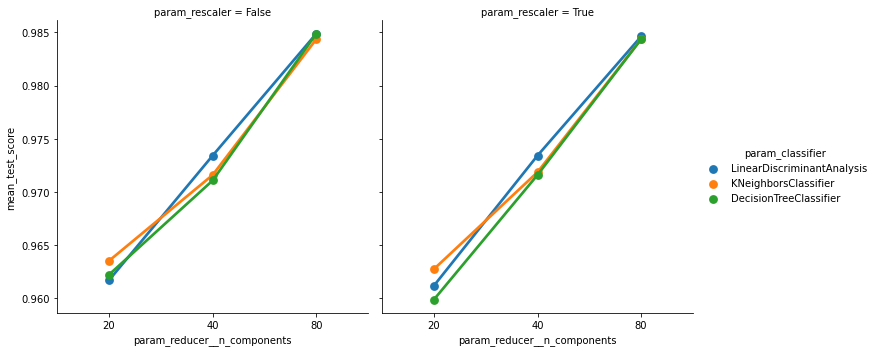

In [21]:
import seaborn as sns
sns.factorplot('param_reducer__n_components','mean_test_score',data=cv_results,
               hue='param_classifier',
               col='param_rescaler',
              )

Both `GridSearchCV` and a fit `Pipeline` objects has the their own internal scikit-learn predict & score methods. 

In the case `GridSearchCV`, this will use the "best estimator" that was identified during the fitting step.

So now we can use the score method to evaluate the model on the held out test data.

In [22]:
grid.score(X_test, y_test)

0.9875

Alternativly, we can extract the pipeline and use it explicity

In [23]:
pipeline = grid.best_estimator_
pipeline.score(X_test,y_test)

0.9875

## Using a pipeline object
One of the distinct advangages of the pipeline object is that you can readily fit a given pipeline to new data.

#### Exersize (1): Earlier, we built an Xbins array. Loop through each in this array and cross validate the pipeline we just built using this new data. Plot the scores relative to the time from stimulus onset. 

Here is some code to get you started:

In [24]:
from matplotlib import pyplot as plt
# Using 5 fold cross validation
scores = np.zeros((5,Xbins.shape[2]))
for tt in range(Xbins.shape[2]):
    this_X = Xbins[:,tt]  
    # YOUR CODE HERE

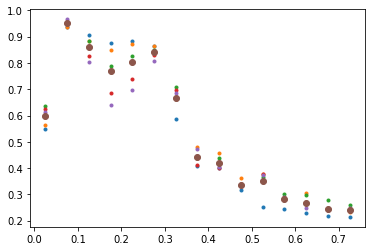

In [25]:
from matplotlib import pyplot as plt

scores = np.zeros((5,Xbins.shape[2]))
for tt in range(Xbins.shape[2]):
    this_X = Xbins[:,:,tt]
    # Solution 
    scores[:,tt] = cross_val_score(pipeline,this_X,y,cv=5)

plt.plot(tme[:-1]+dt/2,scores.T,'.')
plt.plot(tme[:-1]+dt/2,np.mean(scores,axis = 0),'o')


A pipeline can also save you time by streamline preprocessing so you can compare the performance of a decoder trained under one condition to a dataset collected under another condition .This is sometimes a good way to look for changes in population activity between conditions. 

Lets say, for example, you want to train a decoder on image identify durring the 250 ms after stimulus onset, and test it with data between 500 and 750 ms after stimulus onset.



In [26]:
# Sum accross the requisite parts of X to build the matricies described above
X250 = np.sum(Xbins[:,:,tme[:-1]<=250],axis = 2) 
X750 = np.sum(Xbins[:,:,tme[:-1]>500],axis = 2)

#### Exersize (2): fit out pipeline using 'X250', then compare its performance in predicting image identify from 'X750'

In [27]:
# Solution
pipeline.fit(X250,y) # This is the same as what we did before; you could actually just use "grid"
scores = cross_val_score(pipeline,X250,y,cv = 5)
scores

array([0.95729167, 0.97395833, 0.97705944, 0.96976017, 0.97184567])

In [28]:
# Solution
pipeline.score(X750,y)

0.14071294559099437